In [8]:
import numpy as np
from matplotlib import pyplot as plt
# from opfunu.utils import operator
from typing import List, Tuple, Callable

class ATSA:
    def __init__(self, func: Callable, n_trees: int, dim: int, lower_bound: float, upper_bound: float, st: float, optimal_value: float = 0.0):
        """ コンストラクタ
        
        args:
            func (Callable): 最適化関数
            n_trees (int): 木の数
            dim (int): 次元数
            lower_bound (float): 探索空間の下限
            upper_bound (float): 探索空間の上限
            st (float): 探索傾向
        """
        self.func = func
        self.N = n_trees
        self.D = dim
        self.lb = lower_bound
        self.ub = upper_bound
        self.ST = st
        self.MAX_FEs = dim * 1e4 # 最大評価回数
        self.MES  =1e-8 # 収束判定閾値
        self.optimal_value = optimal_value

        self.trees = self.initialize_trees() # 木の位置
        self.fitness = np.array([self.func(tree) for tree in self.trees]) # 各木の評価値

    def initialize_trees(self) -> np.ndarray:
        """ 木の初期化
        
        return:
            trees (np.ndarray): 初期化された木の位置
        """
        trees = self.lb + np.random.uniform(0, 1, (self.N, self.D)) * (self.ub - self.lb)
        return trees
    
    def optimize(self) -> Tuple[np.ndarray, float]:
        """ 最適化の実行
        
        return:
            tuple[np.ndarray, float]: 最適解とその評価値
        """

        ### setep.1 初期化
        self.fes_counter = 0 # 評価回数カウンタ
        self.iter_counter = 0 # イテレーションカウンタ
        self.trees = self.initialize_trees()
        self.fitness = np.array([self.func(tree) for tree in self.trees])
        self.best_tree = self.trees[np.argmin(self.fitness)] # 最良木
        self.best_fitness = np.min(self.fitness) # 最良評価値

        self.history_best_fitness = [self.best_fitness] # 最良評価値の履歴
        self.history_best_tree = [self.best_tree] # 最良木の履歴

        while (True):
            ### 種子の生成
            self.seeds, self.fitness_seeds = self.generate_seeds()

            ### 木の更新
            self.update_trees()

            ### 収束判定
            if (self.optimal_value is not None) and (abs(self.best_fitness - self.optimal_value) < self.MES):
                print(f"Iteration: {self.iter_counter}, Find the optimal solution!")
                break
            elif self.fes_counter >= self.MAX_FEs:
                print(f"Iteration: {self.iter_counter}, Reached the maximum number of function evaluations.")
                break

            self.iter_counter += 1
            if self.iter_counter % 10 == 0:
                print(f"Iteration: {self.iter_counter}, Best fitness: {self.best_fitness}")

        return (self.best_tree, self.best_fitness)

    def generate_seeds(self) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """ 種子の生成
        return:
            tuple[List[np.ndarray], List[np.ndarray]]: 生成された種子とその評価値
        """
        seeds = []
        fitness_seeds = []

        for i in range(self.N):
            num_seeds = int(self.N * np.random.uniform(0.1, 0.25) + 0.5) # 各木が生成する種子の数
            seeds_i = []
            fitness_seeds_i = []
            for _ in range(num_seeds):
                if np.random.rand() < 0.5:
                    if np.random.rand() < self.ST:
                        seed = self.swap(self.best_tree.copy())
                        seed = np.clip(seed, self.lb, self.ub)
                        seeds_i.append(seed)
                        fitness_seeds_i.append(self.func(seed))
                        self.fes_counter += 1
                    else:
                        seed1 = self.swap(self.trees[i].copy())
                        seed1 = np.clip(seed1, self.lb, self.ub)
                        seeds_i.append(seed1)
                        fitness_seeds_i.append(self.func(seed1))
                        seed2 = self.symmetry(self.best_tree.copy())
                        seed2 = np.clip(seed2, self.lb, self.ub)
                        seeds_i.append(seed2)
                        fitness_seeds_i.append(self.func(seed2))
                        self.fes_counter += 2
                else:
                    if np.random.rand() < 0.75:
                        # 最良木に向かう探索
                        seed = self.trees[i] + np.random.uniform(-1.0, 1.0, self.D) * (self.best_tree - self.trees[i])
                        seed = np.clip(seed, self.lb, self.ub)
                        seeds_i.append(seed)
                        fitness_seeds_i.append(self.func(seed))
                        self.fes_counter += 1
                    else:
                        # ランダムな木との探索
                        j = np.random.randint(0, self.N)
                        seed = self.trees[i] + np.random.uniform(-1.0, 1.0, self.D) * (self.trees[j] - self.trees[i])
                        seed = np.clip(seed, self.lb, self.ub)
                        seeds_i.append(seed)
                        fitness_seeds_i.append(self.func(seed))
                        self.fes_counter += 1
                        
            seeds.append(np.array(seeds_i))
            fitness_seeds.append(np.array(fitness_seeds_i))
        return (seeds, fitness_seeds)

    def swap(self, tree: np.ndarray) -> np.ndarray:
        """ 木の2つの要素をランダムに入れ替える
        args:
            tree (np.ndarray): 入れ替え対象の木
        return:
            np.ndarray: 入れ替え後の木
        """
        r1, r2 = np.random.choice(self.D, 2, replace=False)
        tree[r1], tree[r2] = tree[r2], tree[r1]
        return tree

    def symmetry(self, tree: np.ndarray) -> np.ndarray:
        """ 木の中心から左右を入れ替える
        args:
            tree (np.ndarray): 入れ替え対象の木
        return:
            np.ndarray: 入れ替え後の木
        """
        center = np.random.choice(self.D-2) + 1
        max_num_swap = min(center, self.D - center - 1)
        num_swap = np.random.randint(1, max_num_swap + 1)
        for i in range(1, num_swap+1):
            tree[center - i], tree[center + i] = tree[center + i], tree[center - i]
        return tree

    def shift(self, tree: np.ndarray) -> np.ndarray:
        """ 木の要素をランダムにシフトする
        args:
            tree (np.ndarray): シフト対象の木
        return:
            np.ndarray: シフト後の木
        """
        r1, r2 = np.random.choice(self.D, 2, replace=False)
        if r2 < r1:
            r1, r2 = r2, r1
        
        temp = tree[r1+1:r2+1].copy()
        tree[r2] = tree[r1]
        tree[r1:r2] = temp
        return tree

    def update_trees(self) -> None:
        """ 木の更新
        """
        for i in range(self.N):
            # 種子の中で最良のものを選択
            best_seed_idx = np.argmin(self.fitness_seeds[i])
            best_seed = self.seeds[i][best_seed_idx]
            best_seed_fitness = self.fitness_seeds[i][best_seed_idx]

            # 木と種子の比較
            if best_seed_fitness < self.fitness[i]:
                self.trees[i] = best_seed
                self.fitness[i] = best_seed_fitness

                # 全体の最良木の更新
                if best_seed_fitness < self.best_fitness:
                    self.best_tree = best_seed
                    self.best_fitness = best_seed_fitness

        # 履歴の更新
        self.history_best_fitness.append(self.best_fitness)
        self.history_best_tree.append(self.best_tree)

    def plot_history_2Dheatmap(self) -> None:
        """ 最良評価値の履歴を2Dヒートマップで表示（2次元問題専用）
        """
        if self.D != 2:
            raise ValueError("This method is only available for 2D problems.")

        x = np.linspace(self.lb+10, self.ub+10, 100)
        y = np.linspace(self.lb+10, self.ub+10, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.array([[self.func(np.array([x, y])) for x in x] for y in y])
        plt.figure(figsize=(10, 8))
        plt.contourf(X, Y, Z, levels=50, cmap='viridis')
        plt.colorbar(label='Function Value')
        best_trees = np.array(self.history_best_tree)
        plt.plot(best_trees[:, 0], best_trees[:, 1], marker='o', color='red', markersize=5, label='Best Tree Path')
        plt.title('ATSA Optimization Path')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.legend()
        plt.show()

    def plot_history(self) -> None:
        """ 最良評価値の履歴を表示
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.history_best_fitness, marker='o')
        plt.yscale('log')
        plt.title('ATSA Best Fitness History')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness (log scale)')
        plt.grid()
        plt.show()

In [9]:
# func (Callable): 最適化関数
# n_trees (int): 木の数
# dim (int): 次元数
# loweer_bound (float): 探索空間の下限
# upper_bound (float): 探索空間の上限
# st (float): 探索傾向

def func(tree: np.ndarray) -> float:
    """ 最適化関数の例（Rosenbrock関数）
    
    args:
        tree (np.ndarray): 入力木
    return:
        float: 関数の評価値
    """
    return np.sum(tree**2, axis=0)

args = {
    "func": func,
    "n_trees": 10,
    "dim": 20,
    "lower_bound": -100,
    "upper_bound": 100,
    "st": 0.1
}

atsa = ATSA(**args)
best_solution, best_fitness = atsa.optimize()
print("Best solution:", best_solution)
print("Best fitness:", best_fitness)

Iteration: 10, Best fitness: 34193.63164969904
Iteration: 20, Best fitness: 11826.505660275945
Iteration: 30, Best fitness: 4358.347312441041
Iteration: 40, Best fitness: 2433.3720934757416
Iteration: 50, Best fitness: 1165.8038493846202
Iteration: 60, Best fitness: 684.415350840407
Iteration: 70, Best fitness: 335.907323742943
Iteration: 80, Best fitness: 112.399507291895
Iteration: 90, Best fitness: 40.33837274882392
Iteration: 100, Best fitness: 11.909075718615941
Iteration: 110, Best fitness: 6.8250528314290095
Iteration: 120, Best fitness: 2.6838669334045804
Iteration: 130, Best fitness: 1.2348384361325802
Iteration: 140, Best fitness: 0.4393992261102144
Iteration: 150, Best fitness: 0.2995100261649372
Iteration: 160, Best fitness: 0.12322729862301736
Iteration: 170, Best fitness: 0.03706555542316972
Iteration: 180, Best fitness: 0.01860642162400307
Iteration: 190, Best fitness: 0.008686003766401773
Iteration: 200, Best fitness: 0.0022883425531727408
Iteration: 210, Best fitness: 

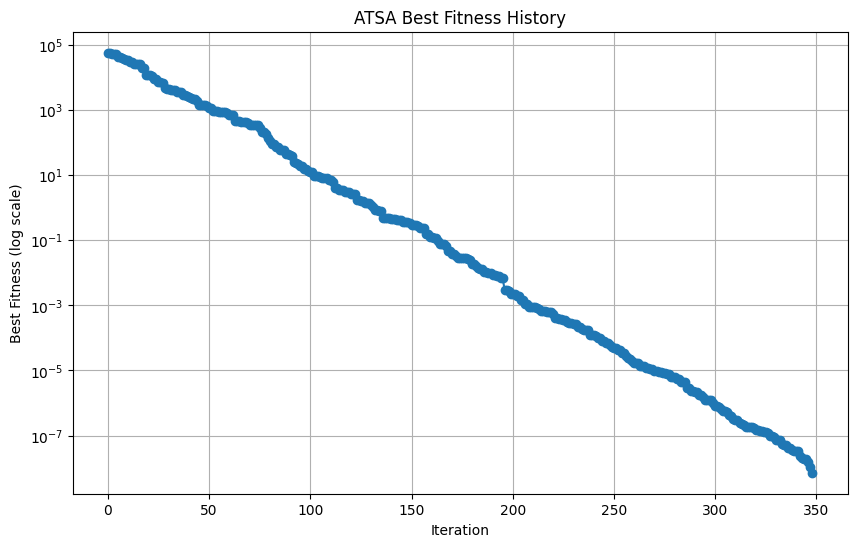

In [10]:
atsa.plot_history()